# Binary classification with un-balanced data

In this notebook, we learn the problems we run into when training a classifier to predict rare events. Many binary classification problems involve rare events, such as predicting that someone has a rare disease, or predicting that someone looking at an add will buy the product. When one of the classes (by convention the positive class) makes up only a very small percentage of the data and most data points belong to the other class (by convention the negative class), we call the uncommon class a **rare event** and we say that we have **unbalanced data**. We explore in this notebook how to unbalanced data affects the way that we evaluate the model.

The Ames housing dataset has housing data including sale price. We create a binary label to flag houses in a price range and build a classifier to predict the likelihood of this price range for a house.  

https://www.kaggle.com/datasets/prevek18/ames-housing-dataset


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.simplefilter("ignore")

In [2]:
from sklearn.datasets import fetch_openml
house_prices = fetch_openml(name="house_prices", as_frame=True)
print('house_prices keys:', house_prices.keys())
ames_df = house_prices.frame # The value for the 'frame' key is a data frame with features and target

house_prices keys: dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])


## Missing Data
The Ames housing data has missing data.  For simplicity sake we will just remove any column that has more than 0.1% missing data.  

In [3]:
original_columns = ames_df.columns
ames_df.loc[ames_df['Electrical'].isna(), 'Electrical'] = 'SBrkr'
ames_df.dropna(axis = 1, inplace = True)
print(original_columns.shape[0], 'columns reduced to', ames_df.columns.shape[0],'columns')

81 columns reduced to 63 columns


## Categorical Columns

In [4]:
original_columns = ames_df.columns
object_columns_before = ames_df.select_dtypes(include=np.object).columns
numeric_columns = ames_df.select_dtypes(include=np.number).columns
print('The data frame has', original_columns.shape[0],
      'columns, including', object_columns_before.shape[0],'categorical columns and',
      numeric_columns.shape[0], 'numeric columns')

The data frame has 63 columns, including 28 categorical columns and 35 numeric columns


### Exercise (4 minutes)

- As one example, recall that earlier in the notebook we used `np.unique(...)` to get counts. Use it to get counts for each unique value of a categorical (object) column with more than 3 values.
- Also turn the counts into percentages.

In [5]:
CategoryCount = np.unique(ames_df['MSZoning'], return_counts=True)
print('Counts for MSZoning categories:\n', CategoryCount)
print('\nMSZoning categories in percent:\n', 100*CategoryCount[1]/np.sum(CategoryCount[1]))

Counts for MSZoning categories:
 (array(['C (all)', 'FV', 'RH', 'RL', 'RM'], dtype=object), array([  10,   65,   16, 1151,  218]))

MSZoning categories in percent:
 [ 0.68493151  4.45205479  1.09589041 78.83561644 14.93150685]


- Since getting counts and turning them into percentages is such a common data-related task, there's got to be an easier way to do it. And there is. Search online to see if `pandas` offers a function for getting unique counts for a column in the data.  Use the pandas method to get the percentages of the categories for `Exterior2nd` and `Neighborhood`.

In [6]:
print('Exterior2nd categories in percent:')
print(ames_df['Exterior2nd'].value_counts(normalize=True)*100)
print('\nNeighborhood categories in percent')
print(ames_df['Neighborhood'].value_counts(normalize=True)*100)

Exterior2nd categories in percent:
VinylSd    34.520548
MetalSd    14.657534
HdBoard    14.178082
Wd Sdng    13.493151
Plywood     9.726027
CmentBd     4.109589
Wd Shng     2.602740
Stucco      1.780822
BrkFace     1.712329
AsbShng     1.369863
ImStucc     0.684932
Brk Cmn     0.479452
Stone       0.342466
AsphShn     0.205479
Other       0.068493
CBlock      0.068493
Name: Exterior2nd, dtype: float64

Neighborhood categories in percent
NAmes      15.410959
CollgCr    10.273973
OldTown     7.739726
Edwards     6.849315
Somerst     5.890411
Gilbert     5.410959
NridgHt     5.273973
Sawyer      5.068493
NWAmes      5.000000
SawyerW     4.041096
BrkSide     3.972603
Crawfor     3.493151
Mitchel     3.356164
NoRidge     2.808219
Timber      2.602740
IDOTRR      2.534247
ClearCr     1.917808
StoneBr     1.712329
SWISU       1.712329
MeadowV     1.164384
Blmngtn     1.164384
BrDale      1.095890
Veenker     0.753425
NPkVill     0.616438
Blueste     0.136986
Name: Neighborhood, dtype: float64

### End of exercise

### Reducing Categorical Complexity
- Category columns will need to be one-hot encoded
- Too many categories will lead to too many feature dimensions
- For simplicity we will drop category columns with too many categories.  Alternatively, we could bin or consolidate similar categories

In [7]:
# Drop category columns with more than 5 categories
column_drop_list = []
for column in object_columns_before:
    if np.unique(ames_df[column]).shape[0] > 5:
        column_drop_list = column_drop_list + [column]
ames_df.drop(columns=column_drop_list, inplace=True)
object_columns_after = ames_df.select_dtypes(include=np.object).columns
print(object_columns_before.shape[0], 'category columns reduced to', object_columns_after.shape[0],'columns')

28 category columns reduced to 15 columns


In [8]:
original_columns = ames_df.columns
ames_df_num = ames_df[numeric_columns].copy() # ames_df.select_dtypes(include=np.number).copy() # only select columns that are numeric
ames_df_cat = ames_df[object_columns_after].copy() # ames_df.select_dtypes('object').copy() # only select columns that have type 'object'
onehot = OneHotEncoder(sparse = False) # initialize one-hot-encoder
onehot.fit(ames_df_cat)
col_names = onehot.get_feature_names_out(ames_df_cat.columns) # this allows us to properly name columns
ames_df_onehot =  pd.DataFrame(onehot.transform(ames_df_cat), columns = col_names)
AmesFeatures = ames_df_num.join(ames_df_onehot)
print(object_columns_after.shape[0], 'categry columns expanded to', ames_df_onehot.columns.shape[0],'columns')
print('Total of', AmesFeatures.columns.shape[0], 'columns')
# AmesFeatures.to_csv('AmesFeatures.csv', index=False)

15 categry columns expanded to 58 columns
Total of 93 columns


Let's now visualize the target variable, housing price.

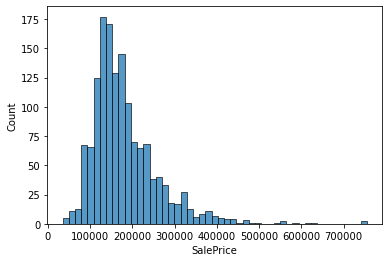

[ 88000. 106475. 163000. 278000. 326100.]


In [9]:
sns.histplot(AmesFeatures.SalePrice)
plt.show()
print(np.quantile(AmesFeatures.SalePrice, [0.05, 0.1, 0.5, 0.9, 0.95]))

Say we're interested in training a classification algorithm to predict whether or not a house is within a specified price range. So first we create a target variable that flags houses who sold in that price range.

In [10]:
y = (AmesFeatures['SalePrice'] > 200000) & (AmesFeatures['SalePrice'] < 230000)
X = AmesFeatures.drop(columns=['SalePrice'])
y.value_counts()

False    1330
True      130
Name: SalePrice, dtype: int64

We start by splitting `X` and `y` into a training data and a testing data. The easiest way to do this is using the `train_test_split` function.

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 0)

### Exercise (6 minutes)

- Find counts for the target in training data

In [12]:
print(y_train.value_counts())
print(y_test.value_counts())

False    930
True      92
Name: SalePrice, dtype: int64
False    400
True      38
Name: SalePrice, dtype: int64


- Train a logistic regression classifier to predict whether the price of a house is within our specified range. Begin by loading the library as such: `from sklearn.linear_model import LogisticRegression`. Then create an instance of the algorithm and train it by invoking the `.fit(X_train, y_train)`.

In [13]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

- Once the model is trained, pass it the testing data to see if we get predictions back. To do so, we invoke the `.predict(x_test)` method. We can also invoke the `.predict_proba(x_test)` method if we wish to get the raw probabilites instead of the final predictions.  Name the predictions `y_test_pred`.

In [14]:
y_train_pred = logreg.predict(X_train)
y_train_proba = logreg.predict_proba(X_train)[:,1]

y_test_pred = logreg.predict(X_test)
y_test_proba = logreg.predict_proba(X_test)[:,1]

- Get the accuracy of the model by loading `from sklearn.metrics import accuracy_score` and calling the `accuracy_score` function. What two arguments do we pass to this function to evaluate the model's accuracy?

In [15]:
from sklearn.metrics import accuracy_score

print('Training "accuracy":', accuracy_score(y_true=y_train, y_pred=y_train_pred))

print('Accuracy (test data):', accuracy_score(y_true=y_test, y_pred=y_test_pred))

Training "accuracy": 0.9099804305283757
Accuracy (test data): 0.91324200913242


- Is accuracy a good metric for evaluating this model? Why or why not? To give some context, let's say you're a developer and want to predict house prices. You prefer to bid low and lose a bid than bid high for a house that's not worth it.

### End of exercise

Let's find some more useful evaluation metrics. The most direct metric to look at, is the confusion matrix.

In [16]:
from sklearn import metrics

cm_train = metrics.confusion_matrix(y_train, y_train_pred)
print('Confusion matrix based on training data:')
print(cm_train)
print('\nConfusion matrix as an accuracy measure (test data):')
cm_test = metrics.confusion_matrix(y_test, y_test_pred)
print(cm_test)

Confusion matrix based on training data:
[[930   0]
 [ 92   0]]

Confusion matrix as an accuracy measure (test data):
[[400   0]
 [ 38   0]]


From the confusion matrix, we can derive accuracy, precision, recall, and the F1-score, which is a sort of average of precision and recall. We don't have time to get into all of them in detail, but [here](http://www.win-vector.com/blog/2009/11/i-dont-think-that-means-what-you-think-it-means-statistics-to-english-translation-part-1-accuracy-measures/) is an excellent article explaining in great detail the differences between each.

In [17]:
from sklearn.metrics import classification_report
print(classification_report(y_train, y_train_pred))
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

       False       0.91      1.00      0.95       930
        True       0.00      0.00      0.00        92

    accuracy                           0.91      1022
   macro avg       0.45      0.50      0.48      1022
weighted avg       0.83      0.91      0.87      1022

              precision    recall  f1-score   support

       False       0.91      1.00      0.95       400
        True       0.00      0.00      0.00        38

    accuracy                           0.91       438
   macro avg       0.46      0.50      0.48       438
weighted avg       0.83      0.91      0.87       438



### ROC:  Gold Standard for Classification Accuracy

One way to visually evaluate a binary classification model is using the ROC plot. The ROC plot is the only metric that can be used by itself and that has some meaning across different data sets.  The area under the ROC plot is called AUC (area under the curve) and the closer it is to 1, the better the model.  An AUC of 0.5 is a random model and is considered to be the worst case scenario.  Such a model is represented by the diagonal from the lower left to the upper right.  (A model that performs below 0.5 with confidence just needs its labels reversed.)

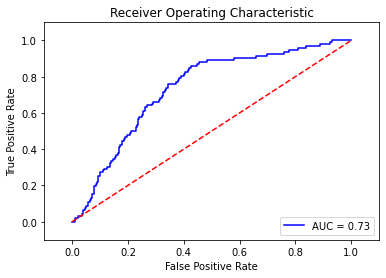

In [18]:
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_train_proba)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

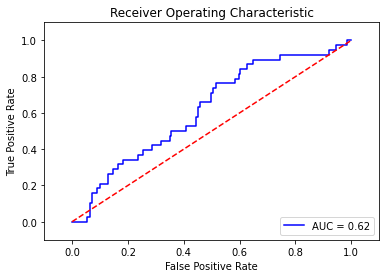

In [19]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_proba)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

- In the above ROC plot for the test data we see a plot whose ROC curve is somewhat above the diagonal.  This means that the probabilities are not very useful.  The AUC is around 0.62 and the scale is from 0.5 to 1.  This AUC indicates that the model is very weak. 

#### Basics on AUC
- For a first understanding of AUC scores we can presume the following (obviously every situation is different and determined by the business use case):
    - A random binary classification model (like a flip of a coin) is 50% (worst accuracy)
    - A barely useable model has an AUC above 0.72. 
    - A good model has an AUC above 0.8.
    - A very good model has an AUC above 0.85
    - A model with an AUC above 0.95 is often an indicator for target leakage
- With the ROC we do not have to worry that the AUC is different for the positive case vs. the negative case as it is for recall, precision and F1 score.  Each of recall, precision, and F1 scores require 2 values, namely one for the positive case and one for the negative case.  The ROCs of a positive case is the mirror image of a negative case.  The AUC of the ROC is the same regardless of which binary outcome is selected as positive.

# Solving Class Imbalance
Now that we have seen how to different approaches to evaluating machine learning models. Let's take a look at solving class imbalance problem. We need to alway make sure to apply downsampling and upsampling to training data only.


https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis

### Down-sampling
- An unbalanced data set is where the classes have different number of cases/observations/rows.  
- The class with the most observations is called the majority class.  
- The class with the least observations is called the minority class.  
- Down-sampling is a technique where the majority class is reduced in size to match the minority class.

In [ ]:
print('The imbalanced class distribution for the train data was {}:{}'
      .format(y_train.shape[0] - np.sum(y_train), np.sum(y_train)))
# Extract positive cases
X_train_pos = X_train.loc[y_train, :]
numberOfRowsPerClass = X_train_pos.shape[0] # np.sum(y_train)
y_train_pos = np.ones(numberOfRowsPerClass, dtype=bool)
# Extract negative cases
X_train_neg = X_train.loc[~y_train, :]
# Down-sample negative cases
X_train_neg_downsample = X_train_neg.sample(n=numberOfRowsPerClass, random_state=0)
y_train_neg_downsample = np.zeros(numberOfRowsPerClass, dtype=bool)

# combine positive and negative cases
X_train_downsample = X_train_pos.append(other=X_train_neg_downsample, ignore_index=True)
y_train_downsample = np.append(arr=y_train_pos, values=y_train_neg_downsample)

print('The balanced class distribution for the down-sampled train data was {}:{}'
      .format(y_train_neg_downsample.shape[0], y_train_pos.shape[0]))

In [ ]:
logregDownSample = LogisticRegression()
logregDownSample.fit(X_train_downsample, y_train_downsample)

y_train_down_pred = logregDownSample.predict(X_train_downsample)
y_train_down_proba = logregDownSample.predict_proba(X_train_downsample)[:,1]

y_test_down_pred = logregDownSample.predict(X_test)
y_test_down_proba = logregDownSample.predict_proba(X_test)[:,1]

print('Training "accuracy":', accuracy_score(y_true=y_train_downsample, y_pred=y_train_down_pred))
print('Accuracy (test data):', accuracy_score(y_true=y_test, y_pred=y_test_down_pred))

cm_down_train = metrics.confusion_matrix(y_train_downsample, y_train_down_pred)
print('Confusion matrix based on down-sampled training data:')
print(cm_down_train)
print('\nConfusion matrix as an accuracy measure (test data):')
cm_down_test = metrics.confusion_matrix(y_test, y_test_down_pred)
print(cm_down_test)

print(classification_report(y_train_downsample, y_train_down_pred))
print(classification_report(y_test, y_test_down_pred))

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_train_downsample, y_train_down_proba)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_down_proba)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
#!pip install imblearn

## Upsampling (Data Augmentation)

https://en.wikipedia.org/wiki/Data_augmentation


In [ ]:
# pip install imblearn

In [ ]:
from imblearn.over_sampling import SMOTE

X_resampled, y_resampled = SMOTE().fit_resample(X_train, y_train)

In [ ]:
y_resampled.value_counts()

In [ ]:
logit_upsample = LogisticRegression(max_iter=5000)
logit_upsample.fit(X_resampled, y_resampled)

In [ ]:
y_train_hat_augment = logit_upsample.predict(X_resampled)
print('Training accuracy score:', accuracy_score(y_true=y_resampled, y_pred=y_train_hat_augment))
cm = metrics.confusion_matrix(y_resampled, y_train_hat_augment)
print(cm)

In [ ]:
y_test_upsample_hat_pred = logit_upsample.predict(X_test)
print('Accuracy score (based on test data):', accuracy_score(y_true=y_test, y_pred=y_test_upsample_hat_pred))
cm = metrics.confusion_matrix(y_test, y_test_upsample_hat_pred)
print(cm)

In [ ]:
print(classification_report(y_test, y_test_upsample_hat_pred))

In [ ]:
y_train_hat_augment_proba = logit_upsample.predict_proba(X_resampled)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_resampled, y_train_hat_augment_proba)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
y_test_hat_augment_proba = logit_upsample.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_hat_augment_proba)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Assignment

The assignment will be posted tomorrow.